In [3]:
import os
import warnings
warnings.filterwarnings("ignore")

import gc
gc.collect()

import cv2
import time
import random
import natsort
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"]=False

# Import pytorch modules
import torch
torch.cuda.empty_cache()

import dlib
from imutils import face_utils
import torchvision.transforms.functional as TF
from torchvision import models
# Import local modules
from src.models.nnabla_model import *
from src.utils.get_list import *
from src.utils.print_overwrite import *

device = 'cuda:2' if torch.cuda.is_available() else 'cpu'

In [2]:
# device = 'cuda:3' if torch.cuda.is_available() else 'cpu'

# SRC_ROOT = "/home/ubuntu/workspace/FLD-scratch/src/"

# INPUT_ROOT = "/data/komedi/k-face-100"
# IMAGE_ROOT = os.path.join(INPUT_ROOT, "cropped_img")
# IMAGE_LIST = get_file_list(IMAGE_ROOT, case="image")

# # pretrained_model = "/home/ubuntu/workspace/FLD-scratch/src/pretrained_model/mobilenet_224_model_best_gdconv_external.pth.tar"
# # model_name = Path(pretrained_model).stem
# model = resnet_depth





In [4]:
import nnabla as nn
import nnabla.parametric_functions as PF
import nnabla.functions as F


def conv_block(x, in_planes, out_planes, test=True):
    residual = x
    out1 = PF.batch_normalization(x, batch_stat=not test, name='bn1')
    out1 = F.relu(out1, True)
    out1 = PF.convolution(out1, int(out_planes / 2), kernel=(3, 3),
                          stride=(1, 1), pad=(1, 1), name='conv1', with_bias=False)

    out2 = PF.batch_normalization(out1, batch_stat=not test, name='bn2')
    out2 = F.relu(out2, True)
    out2 = PF.convolution(out2, int(out_planes / 4), kernel=(3, 3),
                          stride=(1, 1), pad=(1, 1), name='conv2', with_bias=False)

    out3 = PF.batch_normalization(out2, batch_stat=not test, name='bn3')
    out3 = F.relu(out3, True)
    out3 = PF.convolution(out3, int(out_planes / 4), kernel=(3, 3),
                          stride=(1, 1), pad=(1, 1), name='conv3', with_bias=False)

    out3 = F.concatenate(out1, out2, out3, axis=1)

    if in_planes != out_planes:
        residual = PF.batch_normalization(
            residual, batch_stat=not test, name='downsample/0')
        residual = F.relu(residual, True)
        residual = PF.convolution(residual, out_planes, kernel=(
            1, 1), stride=(1, 1), name='downsample/2', with_bias=False)
    out3 += residual
    return out3


def hour_glass(inp, depth, num_features):
    # Upper branch
    up1 = inp
    with nn.parameter_scope('b1_' + str(depth)):
        up1 = conv_block(up1, num_features, num_features)

    # Lower branch
    low1 = F.average_pooling(inp, (2, 2), stride=(2, 2))
    with nn.parameter_scope('b2_' + str(depth)):
        low1 = conv_block(low1, num_features, num_features)

    if depth > 1:
        low2 = hour_glass(low1, depth - 1, num_features)
    else:
        low2 = low1
        with nn.parameter_scope('b2_plus_' + str(depth)):
            low2 = conv_block(low2, num_features, num_features)

    low3 = low2
    with nn.parameter_scope('b3_' + str(depth)):
        low3 = conv_block(low3, num_features, num_features)
    up2 = F.interpolate(low3, scale=(2, 2), mode='nearest')
    return up1 + up2


def fan(x, num_modules=1, test=True):
    x = PF.convolution(x, 64, kernel=(7, 7), stride=(2, 2),
                       pad=(3, 3), name='conv1')
    x = PF.batch_normalization(x, batch_stat=not test, name='bn1')
    x = F.relu(x, True)
    with nn.parameter_scope('conv2'):
        x = conv_block(x, 64, 128)
    x = F.average_pooling(x, (2, 2), stride=(2, 2))
    with nn.parameter_scope('conv3'):
        x = conv_block(x, 128, 128)
    with nn.parameter_scope('conv4'):
        x = conv_block(x, 128, 256)
    previous = x

    outputs = []
    for i in range(num_modules):
        with nn.parameter_scope('m' + str(i)):
            hg = hour_glass(previous, 4, 256)
        ll = hg
        with nn.parameter_scope('top_m_' + str(i)):
            ll = conv_block(ll, 256, 256)
        ll = PF.convolution(ll, 256, kernel=(1, 1), stride=(
            1, 1), pad=(0, 0), name='conv_last' + str(i))
        ll = PF.batch_normalization(
            ll, batch_stat=not test, name='bn_end' + str(i))
        ll = F.relu(ll, True)

        # Predict heatmaps
        tmp_out = PF.convolution(ll, 68, kernel=(
            1, 1), stride=(1, 1), pad=(0, 0), name='l' + str(i))
        outputs.append(tmp_out)

        if i < num_modules - 1:
            ll = PF.convolution(ll, 256, kernel=(1, 1), stride=(
                1, 1), pad=(0, 0), name='bl' + str(i))
            tmp_out_ = PF.convolution(tmp_out, 256, kernel=(
                1, 1), stride=(1, 1), pad=(0, 0), name='al' + str(i))
            previous = previous + ll + tmp_out_
    return outputs


def bottleneck(x, planes, stride=1, downsample=None, test=True):
    residual = x
    out = PF.convolution(x, planes, kernel=(
        1, 1), name='conv1', with_bias=False)
    out = PF.batch_normalization(out, batch_stat=not test, name='bn1')
    out = F.relu(out, True)
    out = PF.convolution(out, planes, kernel=(3, 3), stride=(
        stride, stride), pad=(1, 1), name='conv2', with_bias=False)
    out = PF.batch_normalization(out, batch_stat=not test, name='bn2')
    out = F.relu(out, True)
    out = PF.convolution(out, planes * 4, kernel=(1, 1),
                         name='conv3', with_bias=False)
    out = PF.batch_normalization(out, batch_stat=not test, name='bn3')

    if downsample is not None:
        residual = downsample
    out += residual
    out = F.relu(out, True)
    return out


def create_layer(x, inplanes, planes, blocks, stride=1, test=True):
    downsample = None
    dict = {64: 'layer1', 128: 'layer2', 256: 'layer3', 512: 'layer4'}
    with nn.parameter_scope(dict[planes]):
        with nn.parameter_scope('0'):
            if stride != 1 or inplanes != planes * 4:
                downsample = PF.convolution(x, planes * 4, kernel=(1, 1), stride=(stride, stride),
                                            name='downsample/0',
                                            with_bias=False)
                downsample = PF.batch_normalization(
                    downsample, batch_stat=not test, name='downsample/1')
            layers = bottleneck(x, planes, stride, downsample)
        for i in range(1, blocks):
            with nn.parameter_scope(str(i)):
                layers = bottleneck(layers, planes)
    return layers


def resnet_depth(x, layers=[3, 8, 36, 3], num_classes=68, test=True):
    inplanes = 64
    x = PF.convolution(x, 64, kernel=(7, 7), stride=(2, 2),
                       pad=(3, 3), name='conv1', with_bias=False)
    x = PF.batch_normalization(x, batch_stat=not test, name='bn1')
    x = F.relu(x, True)
    x = F.max_pooling(x, kernel=(3, 3), stride=(2, 2), pad=(1, 1))
    x = create_layer(x, inplanes, 64, layers[0])
    x = create_layer(x, inplanes, 128, layers[1], stride=2)
    x = create_layer(x, inplanes, 256, layers[2], stride=2)
    x = create_layer(x, inplanes, 512, layers[3], stride=2)
    x = F.average_pooling(x, kernel=(7, 7))
    x = F.reshape(x, (x.shape[0], -1))
    x = PF.affine(x, num_classes, name='fc')
    return 

In [5]:
import nnabla as nn
with nn.parameter_scope("ResNetDepth"):
    print("Loading ResNetDepth weights...")
    # nn.load_parameters(resnet_depth_model)

Loading ResNetDepth weights...


In [6]:
nn.parameter_scope("ResNetDepth")

In [2]:
import os
from xml.etree import ElementTree

root_dir = '/data/komedi/dataset/open_dataset/ibug_300W'
tree = ElementTree.parse(os.path.join(root_dir,
                                      f'labels_ibug_300W_{"train"}.xml'))

In [10]:
root = tree.getroot()
filename = root[2]
filename[0].attrib

{'file': 'lfpw/trainset/image_0457.png', 'width': '350', 'height': '464'}

In [ ]:
self.root_dir = '/data/komedi/dataset/open_dataset/ibug_300W'

self.image_paths = []
self.landmarks = []
self.crops = []
self.preprocessor = preprocessor
self.train = train

tree = ElementTree.parse(os.path.join(self.root_dir, f'labels_ibug_300W_{"train" if train else "test"}.xml'))
root = tree.getroot()

for filename in root[2]:
    self.image_paths.append(os.path.join(self.root_dir, filename.attrib['file']))

    self.crops.append(filename[0].attrib)

    landmark = []
    num_list = [0, 2, 5, 8, 11, 14, 16, 17, 19, 21, 22, 24, 26, 27, 29, 30, 31, 33, 35, 36, 39, 42, 45, 48, 51, 54, 57]

    for num in num_list:
        x_coordinate = int(filename[0][num].attrib['x'])
        y_coordinate = int(filename[0][num].attrib['y'])
        landmark.append([x_coordinate, y_coordinate])
    self.landmarks.append(landmark)

self.landmarks = np.array(self.landmarks).astype('float32')

assert len(self.image_paths) == len(self.landmarks)

def __len__(self):
return len(self.image_paths)

def __getitem__(self, index):
image = io.imread(self.image_paths[index], as_gray = False)
landmarks = self.landmarks[index]

image, landmarks = self.preprocessor(image, landmarks, self.crops[index])

return image, landmarks

In [7]:
import pandas as pd
from PIL import Image

In [15]:
data_path = "/data/komedi/dataset/540x1L_kface_nocropped/540_27pt_kface.csv"

In [16]:
data_list = pd.read_csv(data_path, header=None).values.tolist()

In [23]:
cnt = 0

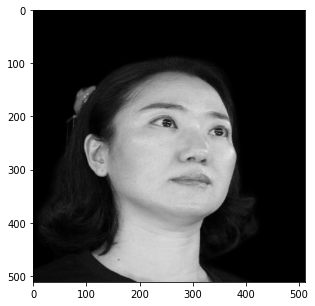

In [66]:
import cv2
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
for cnt in range(540):
    
    image = cv2.cvtColor(cv2.imread(data_list[cnt][2],0),cv2.COLOR_BGR2RGB)
    plt.imshow(image)


In [68]:
image.shape
type(image)

numpy.ndarray